# ****Customer Churn Analysis and Prediction****

### 1. ****Business Understanding****
Churning refers to the number of customers who stopped using a particular product. Customer retention directly affects a company's revenue. Early detecion of customer churn enables businesses to take proactive measures to keep their customers. Knowing how and why customers leave and what can be done to win them back is vital for putting in targetted efforts to enhance customer retention and growth. This project aims to create a machine learning model for early customer churn prediction for the client, a telecommunication company.

### Hypotheses
***Null Hypothesis (H0)***: There is no correlation between Monthly Charges and Churn.

***Alternative Hypothesis (H1)***: Customers with higher Monthly Charges have a significantly higher churn rate.

### Analytical Questions
1. What is the distribution of gender and senior citizenship among customers?
2. Is there a significant difference in churn rate between male and female customers?
3. What is the churn rate for customers who prefer paperless biling compared to those who do not?
4. Does the choice of payment method impact customer churn?
5. How does customer tenure relate to churn rate?



### Import Required Modules

In [72]:
#install openpyxl to be able to open excel files in python
%pip install openpyxl
%pip install -U imbalanced-learn


import pandas as pd
import numpy as np

import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer,LabelEncoder
from sklearn.compose import make_column_selector
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier

warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: openpyxl in c:\users\serwaa\appdata\local\packages\pythonsoftwarefoundation.python.3.11_qbz5n2kfra8p0\localcache\local-packages\python311\site-packages (3.1.2)




[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\Serwaa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: C:\Users\Serwaa\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from imblearn.pipeline import pipeline as imbpipeline

### Getting the datasets from Various Sources

In [3]:
# Load environment variables from .env file into a dictionary
environment_variables=dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
database = environment_variables.get("DATABASE")
server = environment_variables.get("SERVER")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

#code for connection 
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [4]:
# Use the connect method of the pyodbc library and pass in the connection string

connection = pyodbc.connect(connection_string)

Get training dataset from remote SQL Server

In [5]:
#write query statement to get dateset

query = "Select * from dbo.LP2_Telco_churn_first_3000"
df = pd.read_sql(query, connection)
 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


Get testing dataset from a github repository

In [7]:
# get testing data from github repository and read dataset
data = pd.read_csv("C:\\Users\\Serwaa\\OneDrive\\lp2\\Customer-Churn-Analysis\\LP2_Telco-churn-last-2000.csv")

data.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [8]:
print(data['Churn'].unique())


['No' 'Yes']


In [9]:
# Convert 'Churn' to boolean
data['Churn'] = data['Churn'].apply(lambda x: x.lower() == 'yes' if isinstance(x, str) else False)


In [10]:
print(data['Churn'].unique())

[False  True]


In [11]:
# Assuming 'Churn' is a boolean column in your DataFrame
data['Churn'] = data['Churn'].astype(str)


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [13]:
# Convert 'Churn' to boolean
data['PaperlessBilling'] = data['PaperlessBilling'].apply(lambda x: x.lower() == 'yes' if isinstance(x, str) else False)


Get last dataset which will be used for testing the accuracy of the ML models from a gihub repository. 

In [14]:
#read testing dataset 
data_testing = pd.read_excel("C:\\Users\\Serwaa\\onedrive\\lp2\\Customer-Churn-Analysis\\Telco-churn-second-2000.xlsx")
data_testing.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [15]:
#concatenate training datasets
df1 =  pd.concat([df, data])

## ****Data Cleaning and EDA****

In [16]:
#get data shape to know number of rows and columns
df1.shape

(5043, 21)

In [17]:
#check for duplicates in the dataset
df1.duplicated().sum()

0

In [18]:
#get data info
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   bool   
 17  

In [19]:
#get summary statistics of numerical columns
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


In [20]:
#get summary statistics of categorical columns
df1.describe(include="object").T

,count,unique,top,freq
customerID,5043,5043,7590-VHVEG,1
gender,5043,2,Male,2559
Partner,5043,4,False,1538
Dependents,5043,4,False,2070
PhoneService,5043,4,True,2731
MultipleLines,4774,5,False,1437
InternetService,5043,3,Fiber optic,2248
OnlineSecurity,4392,5,False,1478
OnlineBackup,4392,5,False,1320
DeviceProtection,4392,5,False,1296


In [21]:
#check for missing values
df1.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [22]:
#check for unique values for 'Churn' column
print(df1['Churn'].unique())


[False True None 'False' 'True']


In [23]:
df1.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

In [24]:
# Convert 'True' and 'False' strings to boolean
df1['Churn'] = df1['Churn'].str.lower().eq('true')

# Convert 'Churn' to integer
df1['Churn'] = df1['Churn'].astype(int)


In [25]:
df1.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 0
dtype: int64

In [26]:
df1.shape

(5043, 21)

In [27]:
#convert Total charges to a numeric datatype for further analysis

df1['TotalCharges'] = pd.to_numeric(df1['TotalCharges'], errors='coerce')



In [28]:
df1.to_csv('df1.csv', index = False)

In [29]:
df1.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 0
dtype: int64

****Univariate analysis for some columns of interest****


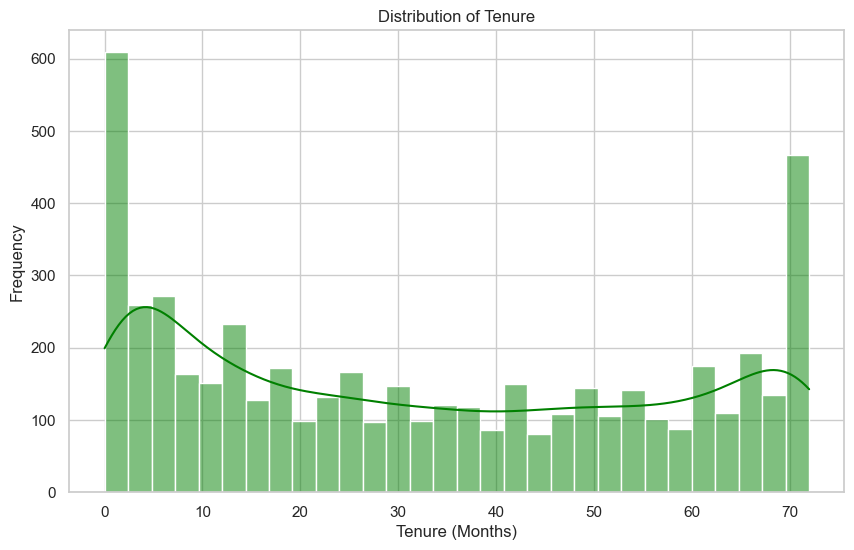

In [30]:

# Set the style for the plots
sns.set(style="whitegrid")

# Univariate Analysis for 'tenure'
plt.figure(figsize=(10, 6))
sns.histplot(df1['tenure'], bins=30, kde=True, color='green')
plt.title('Distribution of Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Frequency')
plt.show()

The distribution of tenure (customer tenure in months) somewhat assymetrical, indicating that a significant number of customers have relatively shorter tenures with some others having long tenures.
This suggests that the customer base may have a mix of both long-term and short-term customers.

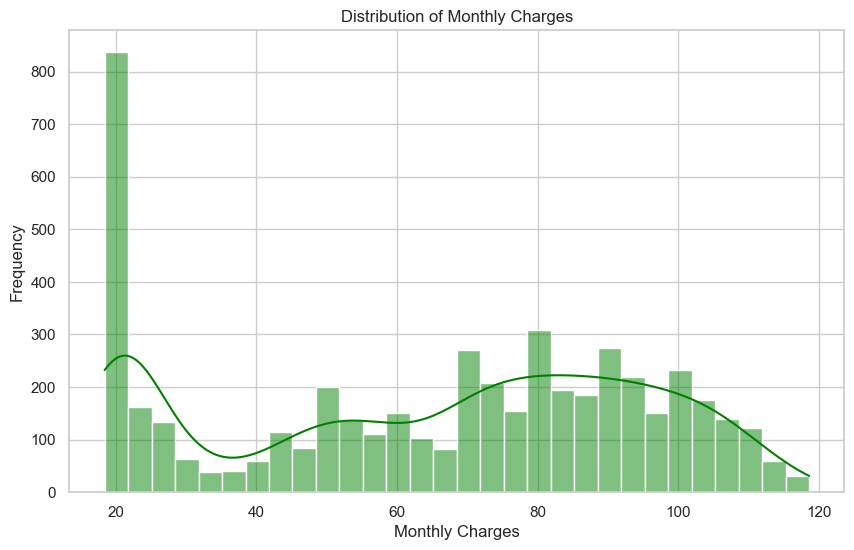

In [31]:
# Univariate Analysis for 'MonthlyCharges'
plt.figure(figsize=(10, 6))
sns.histplot(df1['MonthlyCharges'], bins=30, kde=True, color='green')
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.show()

The distribution of monthly charges is somewhat bimodal, indicating the presence of two peaks or groups of customers with different spending patterns.
It might be interesting to investigate the factors contributing to the two groups and whether they have different churn behaviors.

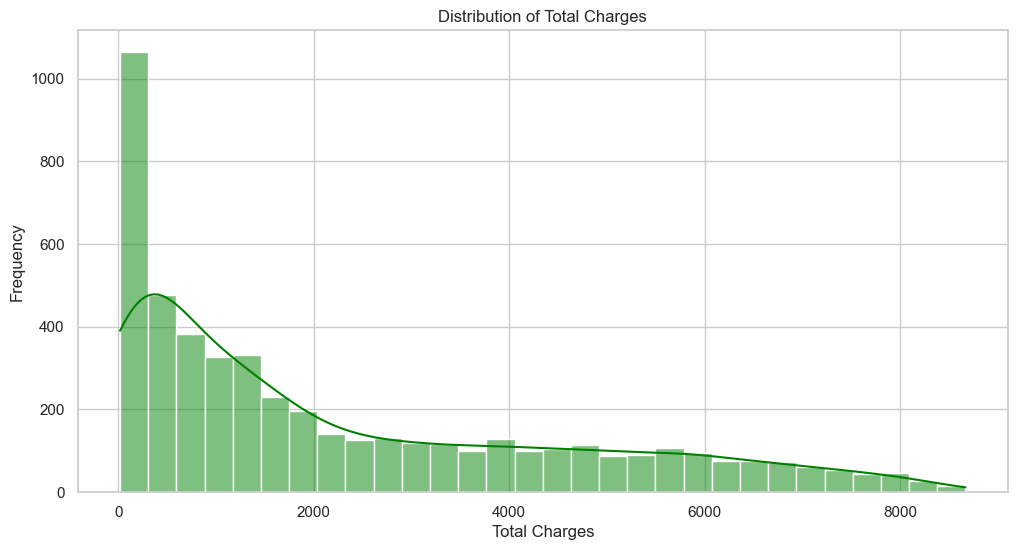

In [32]:
# Univariate Analysis for 'TotalCharges'
plt.figure(figsize=(12, 6))
sns.histplot(df1['TotalCharges'], bins=30, kde=True, color='green')
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

The distribution of total charges shows a positively skewed pattern, suggesting that there are a few customers with very high total charges Exploring this group could reveal insights into what makes them loyal and how we can enhance their experience.

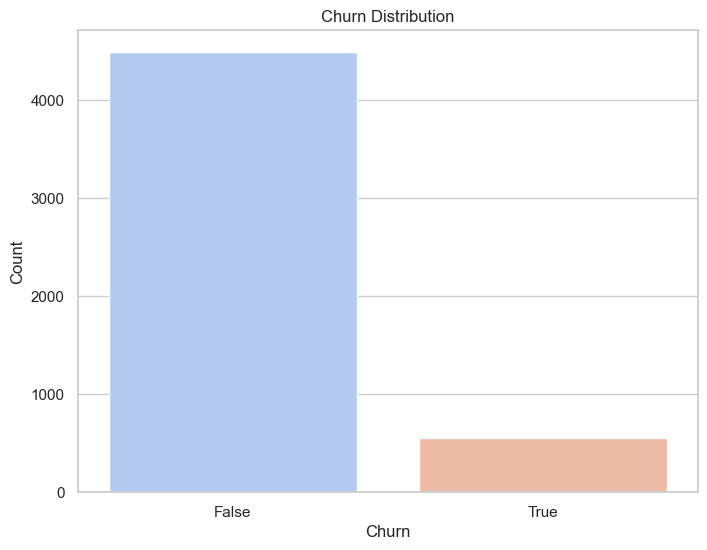

In [33]:
# Univariate Analysis for 'Churn'

# Create a count plot with custom tick labels
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df1, palette='coolwarm')

# Customize the tick labels
plt.xticks([0, 1], ['False', 'True'], rotation=0)

plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

The count plot for churn indicates the distribution of customers between those who churned ('True') and those who did not ('False'). Those who churned are very few compared to those who did not.
The class imbalance in the target variable ('Churn') should be considered when building machine learning models

In [34]:
df1.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 0
dtype: int64

****Bivariate Analysis****

<Axes: >

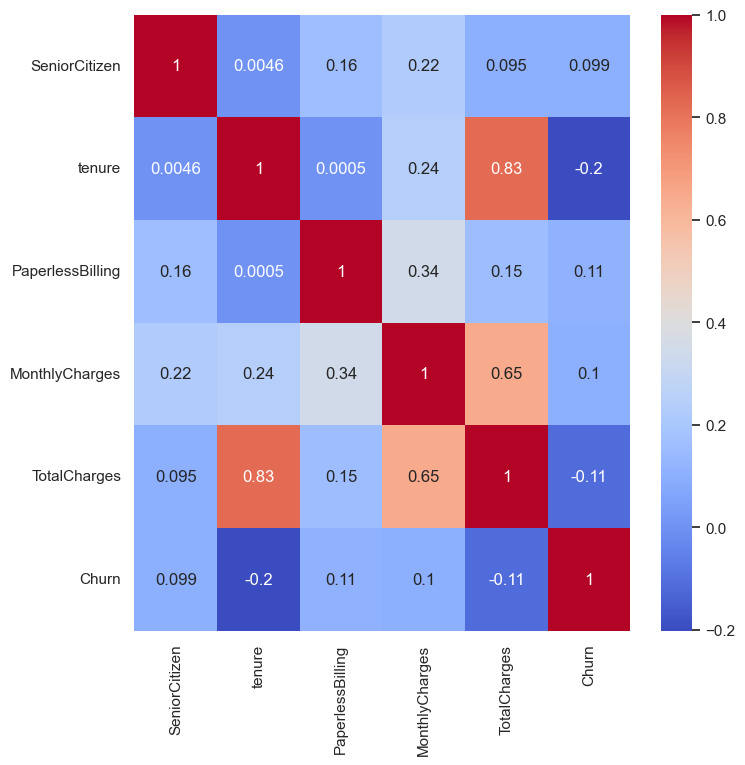

In [35]:
#plot a heatmap to show the correlations between the columns/features

correlation = df1.corr(numeric_only=True)
plt.figure(figsize=(8,8))
sns.heatmap(data=correlation, annot=True, cmap='coolwarm')

There is a weak negative correlation between tenure and churn. As tenure (customer loyalty) increases, there is a slight tendency for churn to decrease. This means longer-tenured customers may be more likely to stay with the service.

There is weak positive correlation between monthly charges and churn. Higher monthly charges are associated with a slightly higher likelihood of churn. This suggests that customers with higher charges may be more sensitive to pricing.

Also, there is Moderate positive correlation between monthly charges and total charges. This suggests that customers with higher monthly charges tend to have higher total charges, indicating that the two variables are positively associated.
There is also a strong positive correlation between tenure and total charges meaning customers with longer tenure tend to have higher total charges, suggesting that loyal customers accumulate more charges over time.

***Bivariate analysis for some columns of interest***

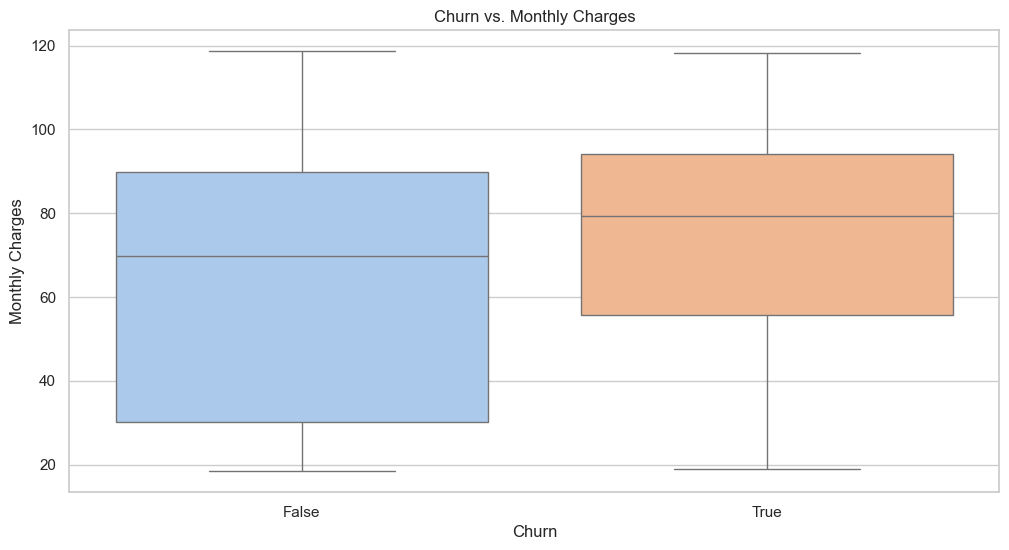

In [36]:

# Bivariate Analysis: Churn vs. Monthly Charges
# Set the style for the plot

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
plt.xticks([0, 1], ['False', 'True'], rotation=0)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df1, palette='pastel')
plt.title('Churn vs. Monthly Charges')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.show()


Insight: Customers who churn tend to have higher monthly charges on average compared to those who do not churn. This suggests that customers with higher monthly charges might be more likely to churn.

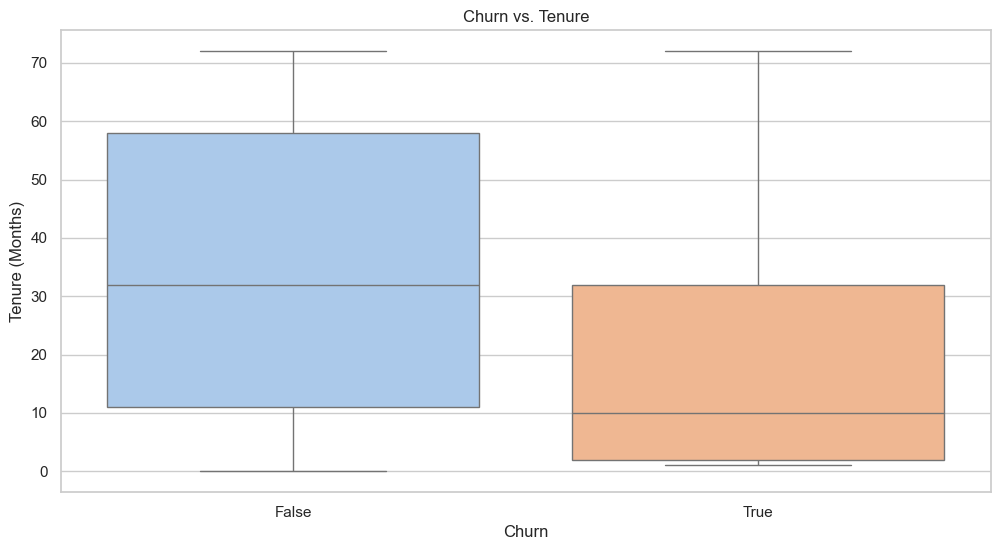

In [37]:
# Bivariate Analysis: Churn vs. Tenure
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.xticks([0, 1], ['False', 'True'], rotation=0)
sns.boxplot(x='Churn', y='tenure', data=df1, palette="pastel")
plt.title('Churn vs. Tenure')
plt.xlabel('Churn')
plt.ylabel('Tenure (Months)')
plt.show()


Insight: Customers who churn generally have shorter tenure compared to customers who do not churn. This implies that newer customers may be more prone to churning.

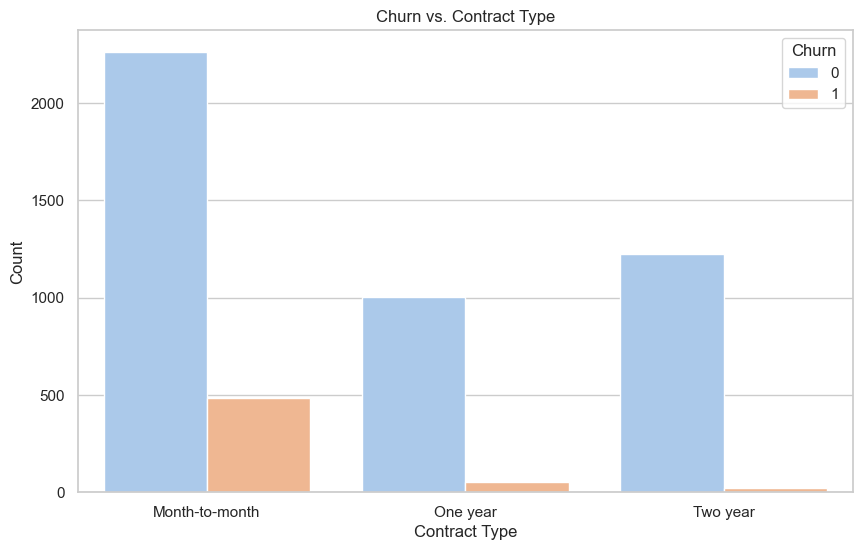

In [38]:
# Bivariate Analysis: Churn vs. Contract Type

plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=df1, palette='pastel')
plt.title('Churn vs. Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.show()


Insight: Customers with month-to-month contracts are more likely to churn compared to those with one-year or two-year contracts. Long-term contract holders have a lower churn rate, indicating that contract type is a significant factor in customer retention

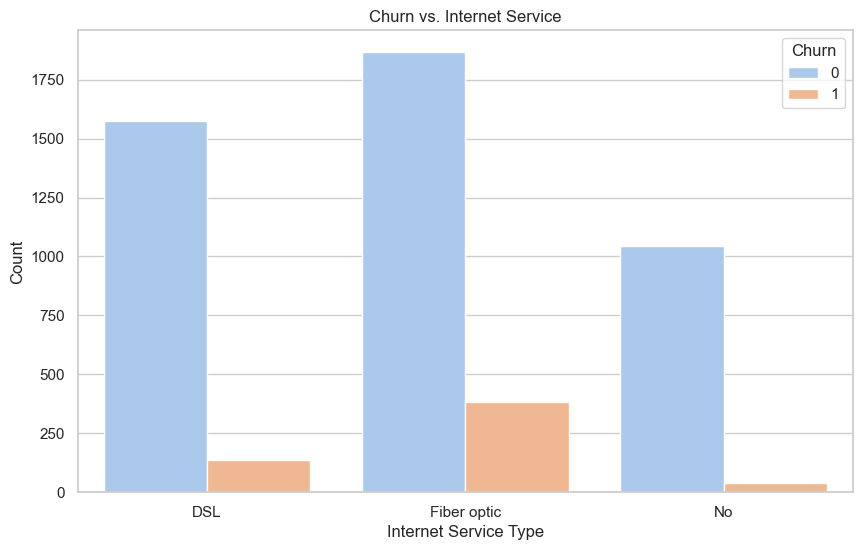

In [39]:
# Bivariate Analysis: Churn vs. Internet Service

plt.figure(figsize=(10, 6))
sns.countplot(x='InternetService', hue='Churn', data=df1, palette='pastel')
plt.title('Churn vs. Internet Service')
plt.xlabel('Internet Service Type')
plt.ylabel('Count')
plt.show()


Insight: Customers with fiber optic internet service are more likely to churn compared to those with DSL or no internet service. This suggests that the type of internet service may impact customer satisfaction and retention.

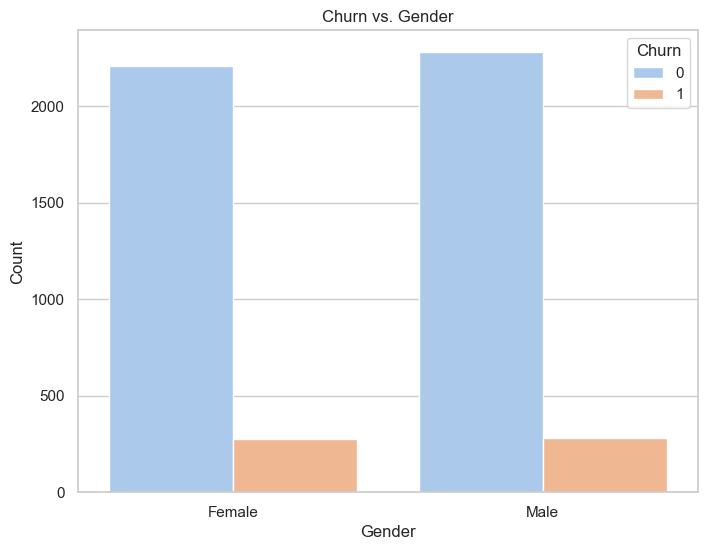

In [40]:
# Bivariate Analysis: Churn vs. Gender

plt.figure(figsize=(8, 6))
sns.countplot(x='gender', hue='Churn', data=df1, palette='pastel')
plt.title('Churn vs. Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


Insight: There doesn't appear to be a significant difference in churn between male and female customers. Churn rates seem comparable across gender groups, indicating that gender may not be a strong predictor of churn in this dataset.

In [41]:
df1.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 0
dtype: int64

****Multivariate Analysis****

<Figure size 1200x1200 with 0 Axes>

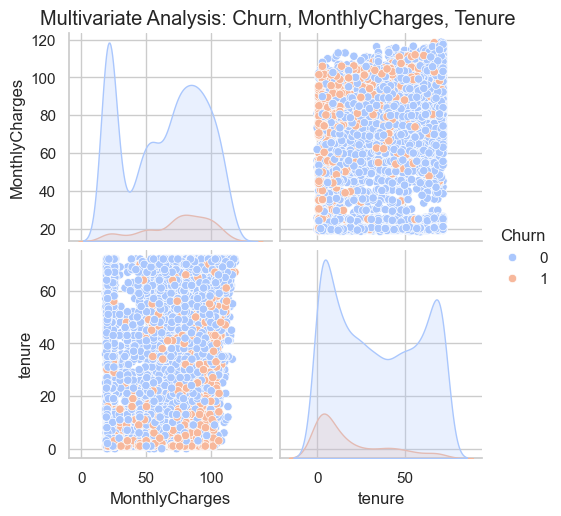

In [42]:
# columns of interest for this analysis are; Churn, Monthly charges, Tenure

# Subset the DataFrame for relevant columns
subset_df = df1[['Churn', 'MonthlyCharges', 'tenure']]
plt.figure(figsize=(12,12))
# Create a pair plot
sns.pairplot(subset_df, hue='Churn', palette='coolwarm')
plt.suptitle('Multivariate Analysis: Churn, MonthlyCharges, Tenure', y=1.02)
plt.show()





Customers who churn tend to have higher monthly charges and shorter tenure.This suggests that customers with higher monthly charges and shorter tenure are more likely to churn. It aligns with the previous bivariate analyses where we observed higher monthly charges and shorter tenure associated with churn

Also, monthly charges and tenure exhibit some degree of negative correlation.
As tenure increases, there's a tendency for monthly charges to decrease. This could mean that long-term customers might be on older, lower-priced plans or that the company offers incentives for loyalty.

In [43]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   bool   
 17  

In [44]:
df1.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 0
dtype: int64

### ****Answering Analytical Questions****

1. ***What is the distribution of gender and senior citizenship among customers?***

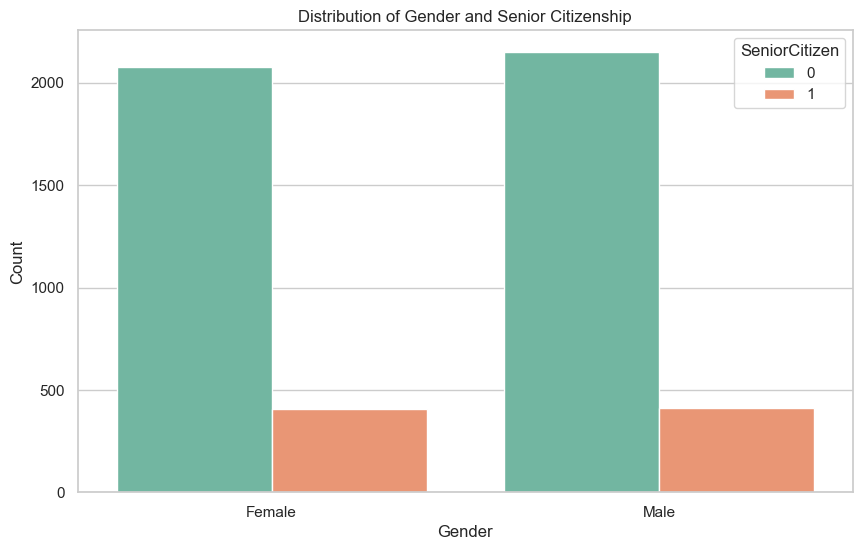

In [45]:
#create a countplot to visualize the distribution of the 'gender' variable with respect to the 'SeniorCitizen' variable.

plt.figure(figsize=(10, 6)) #set figure size
sns.set_palette("Set2")  #set colour palette

sns.countplot(x='gender', hue='SeniorCitizen', data=df1)
plt.title('Distribution of Gender and Senior Citizenship')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()



This plot shows a general demographic of customers. While the majority are non-senior citizens, there are notable segments of senior citizens within both genders. Exploring churn patterns within these segments can guide targeted retention strategies and inform tailored marketing campaigns for enhanced customer satisfaction and loyalty.

2. ***Is there a significant difference in churn rate between male and female customers?***

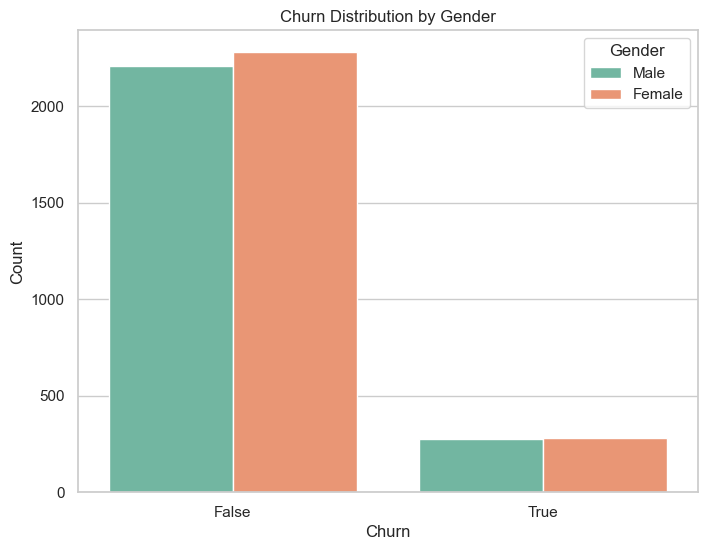

Churn      False     True 
gender                    
Female  0.737526  0.262474
Male    0.742188  0.257812


In [46]:
#set figure size and preffered palette 
# also, customize x-axis ticks positions and labels for more meaningful labels
plt.figure(figsize=(8, 6))
plt.xticks([0, 1], ['False', 'True'], rotation=0)
sns.set_palette("Set2")

# Create a countplot for the distribution of churn based on gender
sns.countplot(x='Churn', hue='gender', data=df1, palette="Set2")

plt.title('Churn Distribution by Gender')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.legend(title='Gender', labels=['Male', 'Female'])
plt.show()

# Additionally, Calculate churn rates for male and female customers
churn_rates = df.groupby('gender')['Churn'].value_counts(normalize=True).unstack()

print(churn_rates)

For female customers, the churn rate is approximately 27% and for male customers, the churn rate is approximately 26%.
There is a marginal difference in churn rates between male and female customers, with female customers having a slightly higher churn rate.

3. ***What is the churn rate for customers who prefer paperless biling compared to those who do not?***


Churn Rates by Paperless Billing Preference:
Churn                    0         1
PaperlessBilling                    
False             0.932584  0.067416
True              0.860481  0.139519


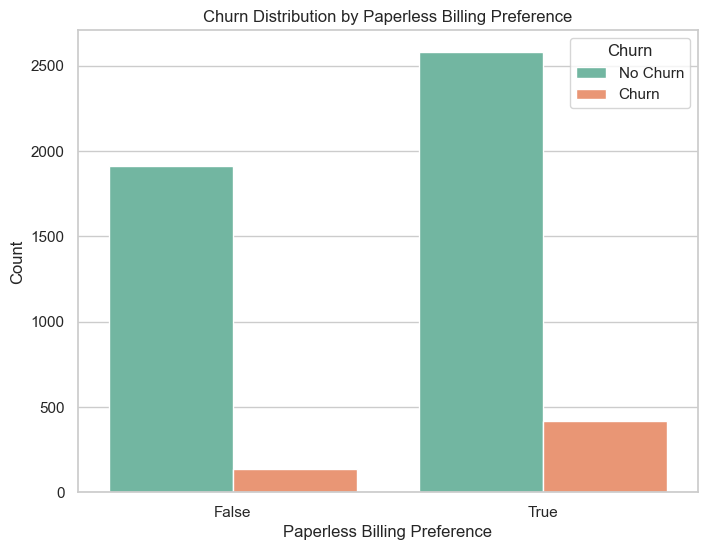

In [47]:
# Plot Churn Distribution by Paperless Billing Preference
plt.figure(figsize=(8, 6))
sns.set_palette("Set2")

# Create a countplot for the distribution of churn based on paperless billing preference
sns.countplot(x='PaperlessBilling', hue='Churn', data=df1, palette='Set2')

plt.title('Churn Distribution by Paperless Billing Preference')
plt.xlabel('Paperless Billing Preference')
plt.ylabel('Count')
plt.legend(title='Churn', labels=['No Churn', 'Churn'])

# Calculate churn rates for customers based on paperless billing preference
churn_rates_paperless = df1.groupby('PaperlessBilling')['Churn'].value_counts(normalize=True).unstack()

# Replace NaN with 0 in the churn rates
churn_rates_paperless = churn_rates_paperless.fillna(0)

# Print the churn rates
print("\nChurn Rates by Paperless Billing Preference:")
print(churn_rates_paperless)

plt.show()



False (Paperless Billing):Churn Rate 0: Approximately 93.2%
                          Churn Rate 1: Approximately 6.8%
                          
True (Paperless Billing):Churn Rate 0: Approximately 86.0%
                         Churn Rate 1: Approximately 13.9%
                         
This suggests that customers with Paperless Billing (True) have a higher churn rate compared to those without Paperless Billing (False). The majority of customers without Paperless Billing tend to stay with the service, while a relatively higher proportion of customers with Paperless Billing experience churn.

4. ***Does the choice of payment method impact customer churn?***

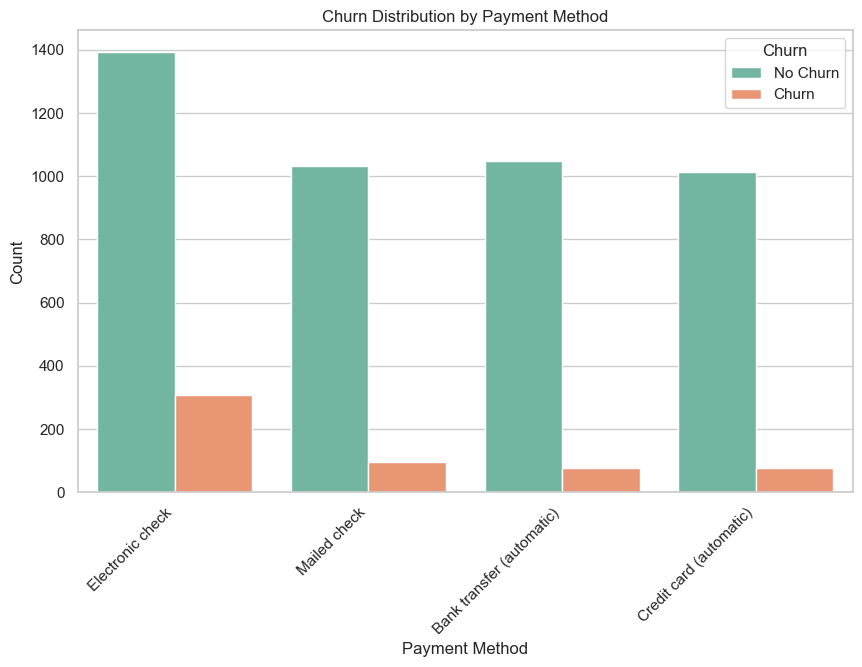

Churn                         False     True 
PaymentMethod                                
Bank transfer (automatic)  0.822416  0.177584
Credit card (automatic)    0.861492  0.138508
Electronic check           0.551346  0.448654
Mailed check               0.820552  0.179448


In [48]:
#set figure size and preffered colour palette
plt.figure(figsize=(10, 6))
sns.set_palette("Set2")

# Create a countplot for the distribution of churn based on payment method
sns.countplot(x='PaymentMethod', hue='Churn', data=df1, palette="Set2")

plt.title('Churn Distribution by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  
plt.legend(title='Churn', labels=['No Churn', 'Churn'])
plt.show()

# In addition, Calculate churn rates for customers based on payment method
churn_rates_payment = df.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack()

# Print the churn rates
print(churn_rates_payment)

Bank Transfer (Automatic): Churn rate of approximately 18%.
Credit Card (Automatic): Churn rate of approximately 14%.
Electronic Check: Churn rate of approximately 45%.
Mailed Check: Churn rate of approximately 18%.

Notable variations in churn rates are observed across different payment methods.Electronic Check users have a significantly higher churn rate compared to other payment methods.The high churn rate for Electronic Check users suggests a potential correlation between this payment method and churn behavior. Consider alternative payment methods or implement strategies to improve customer retention for this segment.

5. ***What is the average monthly charge of customers who churned?***

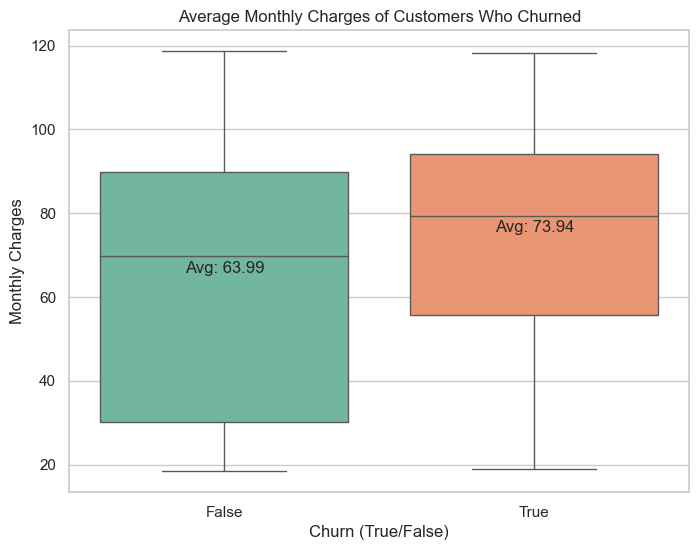

In [49]:
# Calculate average monthly charges for each group
avg_monthly_charges = df1.groupby('Churn')['MonthlyCharges'].mean()

# Create a boxplot for MonthlyCharges of customers who churned
plt.figure(figsize=(8, 6))
plt.xticks([0, 1], ['False', 'True'], rotation=0)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df1, palette='Set2')
plt.title('Average Monthly Charges of Customers Who Churned')
plt.xlabel('Churn (True/False)')
plt.ylabel('Monthly Charges')

# Add text annotation for average values
for i, value in enumerate(avg_monthly_charges):
    plt.text(i, value + 1, f'Avg: {value:.2f}', ha='center', va='bottom')

plt.show()

The average monthly charge for churned customers is higher than for non-churned customers.This implies that, on average, customers who churned had higher monthly charges.Higher average monthly charges for churned customers could be a factor contributing to customer churn.
Further analysis and context are needed to understand the specific dynamics between monthly charges and customer behavior.

In [50]:
df1.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 0
dtype: int64

In [51]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   bool   
 17  

Column transformations before Machine learning Pipeline

In [52]:
df1=df1.drop('customerID', axis=1)

In [53]:
df1['gender'] = df1['gender'].astype(str)

In [54]:
df1['Partner'] = df1['Partner'].astype(str)

In [55]:
df1['DeviceProtection'] = df1['DeviceProtection'].astype(str)

In [56]:
df1['InternetService']= df1['InternetService'].astype(str)

In [57]:
df1['MultipleLines'] = df1['MultipleLines'].astype(str)

In [58]:
df1['OnlineBackup'] = df1['OnlineBackup'].astype(str)

In [59]:
df1['OnlineSecurity'] = df1['OnlineSecurity'].astype(str)

In [60]:
df1['PaperlessBilling'] = df1['PaperlessBilling'].astype(str)

In [61]:
df1['PhoneService'] = df1['PhoneService'].astype(str)

In [62]:
df1['StreamingMovies'] = df1['StreamingMovies'].astype(str)

In [63]:
df1['StreamingTV'] = df1['StreamingTV'].astype(str)

In [64]:
df1['TechSupport'] = df1['TechSupport'].astype(str)

In [65]:
df1[''] = df1['gender'].astype(str)

## ****Data Preparation And Model Training****

The dataset is split into training and testing datasets

In [66]:
#the dataset is first split into the target variable 'y'(Churn) and the input variables' X'
X = df1.drop('Churn', axis = 1)

y = df1['Churn']

In [67]:
#split dataset into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42,stratify=y)


In [68]:
# Encode categorical variables
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)


### Pipelines

In [69]:
# Identify numerical and categorical columns
numerical_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaymentMethod']

In [70]:

# LogTransformer class
class LogTransformer:
    def __init__(self, constant=1):
        self.constant = constant

    def transform(self, X_train):
        return np.log1p(X_train + self.constant)


# Numerical transformer with LogTransformer
num_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('log_transform', FunctionTransformer(LogTransformer().transform)),
    ('scaler', StandardScaler())
])
from sklearn.base import TransformerMixin

class BooleanToStringTransformer(TransformerMixin):
    def fit(self, X, y=None):
        # Fit logic here, if needed
        return self

    def transform(self, X):
        # Transformation logic here
        # Ensure to return the transformed data
        return X.astype(str)


# Categorical transformer
cat_pipeline = Pipeline(steps=[
    ('bool_to_str', BooleanToStringTransformer()),
    ('cat_imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('cat_encoder', OneHotEncoder())
])


# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_cols),
        ('cat', cat_pipeline, categorical_cols)
    ])




### ****Machine Learning Pipelines****

#### Model Training and Comparison 

In [74]:
# Define models
models = [
    ('Tree_classifier', DecisionTreeClassifier(random_state=42)),
    ('SVC_classifier', SVC(random_state=42)),
    ('RF_classifier', RandomForestClassifier(random_state=42)),
    ('SGD_classifier', SGDClassifier(random_state=42)),
    ('LR_classifier', LogisticRegression(random_state=42)),
    ('KNN_classifier', KNeighborsClassifier())
]

# Initialize empty lists to store metrics
accuracy_list = []
precision_0_list = []
precision_1_list = []
recall_0_list = []
recall_1_list = []
f1_0_list = []
f1_1_list = []
support_0_list = []
support_1_list = []
micro_avg_list = []
weighted_avg_list = []
model_names = [] 

# Loop through models and create pipelines
for model_name, classifier in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    accuracy_list.append(accuracy_score(y_test, y_pred))

    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    micro_avg, weighted_avg = precision_recall_fscore_support(y_test, y_pred, average='micro'), precision_recall_fscore_support(y_test, y_pred, average='weighted')

    precision_0_list.append(precision[0])
    precision_1_list.append(precision[1])
    recall_0_list.append(recall[0])
    recall_1_list.append(recall[1])
    f1_0_list.append(f1[0])
    f1_1_list.append(f1[1])
    support_0_list.append(support[0])
    support_1_list.append(support[1])
    micro_avg_list.append(micro_avg)
    weighted_avg_list.append(weighted_avg)

    # Append the model_name to the list for each iteration
    model_names.append(model_name)

# Create DataFrames for each model
dataframes = []
for i in range(len(models)):
    df = pd.DataFrame({
        'Model': [model_names[i]],
        'Accuracy': [accuracy_list[i]],
        'Precision_0': [precision_0_list[i]],
        'Precision_1': [precision_1_list[i]],
        'Recall_0': [recall_0_list[i]],
        'Recall_1': [recall_1_list[i]],
        'F1-Score_0': [f1_0_list[i]],
        'F1-Score_1': [f1_1_list[i]],
        'Support_0': [support_0_list[i]],
        'Support_1': [support_1_list[i]],
        'Micro Avg': [micro_avg_list[i]],
        'Weighted Avg': [weighted_avg_list[i]]
    })
    dataframes.append(df)

# Concatenate DataFrames into a single DataFrame
comparison_table = pd.concat(dataframes, ignore_index=True)
# Display the comparison table
print(comparison_table)
    

             Model  Accuracy  Precision_0  Precision_1  Recall_0  Recall_1  \
0  Tree_classifier  0.882061     0.934225     0.464286  0.933185  0.468468   
1   SVC_classifier  0.907830     0.925926     0.640625  0.974388  0.369369   
2    RF_classifier  0.905847     0.928495     0.611111  0.968820  0.396396   
3   SGD_classifier  0.906838     0.906061     0.947368  0.998886  0.162162   
4    LR_classifier  0.910803     0.935345     0.629630  0.966592  0.459459   
5   KNN_classifier  0.908821     0.937093     0.609195  0.962138  0.477477   

   F1-Score_0  F1-Score_1  Support_0  Support_1  \
0    0.933705    0.466368        898        111   
1    0.949539    0.468571        898        111   
2    0.948229    0.480874        898        111   
3    0.950212    0.276923        898        111   
4    0.950712    0.531250        898        111   
5    0.949451    0.535354        898        111   

                                           Micro Avg  \
0  (0.8820614469772051, 0.8820614469772

#### ****Evaluation****

****Analysis:****

*Accuracy: Logistic Regression (LR_classifier) has the highest accuracy (91.08%).

*Precision: Logistic Regression has the highest precision for both classes.

*Recall: Logistic Regression has the highest recall for class 0, while Tree_classifier has the highest recall for class 1.

*F1-Score: Logistic Regression has the highest F1-Score for both classes.

*Support: The support values indicate the number of instances for each class.

Considering a balance between precision, recall, and F1-Score, Logistic Regression appears to be the best-performing model in this comparison.

#### ****Balancing the Dataset****

In [75]:
# Drop unnamed column

X_train = X_train.drop('', axis=1) 

In [76]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
55,Female,1,Yes,No,53,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,False,Credit card (automatic),25.100000,1275.600000
735,Male,0,True,True,32,False,None,DSL,False,False,True,False,True,True,Month-to-month,False,Credit card (automatic),50.599998,1653.449951
948,Male,1,False,False,35,True,True,Fiber optic,False,False,True,False,True,True,Month-to-month,True,Electronic check,99.050003,3395.800049
622,Male,0,No,No,23,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,True,Mailed check,104.050000,2470.100000
1330,Male,0,True,False,22,True,False,DSL,True,False,False,True,False,False,One year,True,Credit card (automatic),56.250000,1292.199951


In [77]:
# Reset the index and drop the unnamed column
X_train = X_train.reset_index(drop=True)

# Check if X_train contains any non-numeric columns
non_numeric_columns = X_train.select_dtypes(exclude=['number']).columns
print("Non-numeric columns in X_train:", non_numeric_columns)


Non-numeric columns in X_train: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [78]:
from imblearn.pipeline import Pipeline as imbpipeline

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SGD': SGDClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'LR': LogisticRegression(random_state=42)
}

# Initialize empty lists to store metrics
accuracy_list = []
precision_0_list = []
precision_1_list = []
recall_0_list = []
recall_1_list = []
f1_0_list = []
f1_1_list = []
support_0_list = []
support_1_list = []
micro_avg_list = []
weighted_avg_list = []
model_names = [] 

# Loop through classifiers and create pipelines
for name, classifier in classifiers.items():
    print(f"Training and evaluating {name} with SMOTE")

    # Create an imbalanced pipeline
    pipeline = imbpipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', classifier)
    ])
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train_encoded)

    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    micro_avg, weighted_avg = precision_recall_fscore_support(y_test, y_pred, average='micro'), precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Append metrics to lists
    accuracy_list.append(accuracy)
    precision_0_list.append(precision[0])
    precision_1_list.append(precision[1])
    recall_0_list.append(recall[0])
    recall_1_list.append(recall[1])
    f1_0_list.append(f1[0])
    f1_1_list.append(f1[1])
    support_0_list.append(support[0])
    support_1_list.append(support[1])
    micro_avg_list.append(micro_avg)
    weighted_avg_list.append(weighted_avg)

    # Append the model_name to the list for each iteration
    model_names.append(name)

# Create DataFrame for the comparison table
comparison_table = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_list,
    'Precision_0': precision_0_list,
    'Precision_1': precision_1_list,
    'Recall_0': recall_0_list,
    'Recall_1': recall_1_list,
    'F1-Score_0': f1_0_list,
    'F1-Score_1': f1_1_list,
    'Support_0': support_0_list,
    'Support_1': support_1_list,
    'Micro Avg': micro_avg_list,
    'Weighted Avg': weighted_avg_list
})

# Display the comparison table
print(comparison_table)

Training and evaluating Random Forest with SMOTE


Training and evaluating SVM with SMOTE
Training and evaluating KNN with SMOTE
Training and evaluating SGD with SMOTE
Training and evaluating Decision Tree with SMOTE
Training and evaluating LR with SMOTE
           Model  Accuracy  Precision_0  Precision_1  Recall_0  Recall_1  \
0  Random Forest  0.911794     0.949944     0.600000  0.951002  0.594595   
1            SVM  0.871160     0.980000     0.454545  0.873051  0.855856   
2            KNN  0.844400     0.976834     0.400862  0.845212  0.837838   
3            SGD  0.861249     0.987147     0.437229  0.855234  0.909910   
4  Decision Tree  0.897919     0.953250     0.530303  0.930958  0.630631   
5             LR  0.859267     0.987113     0.433476  0.853007  0.909910   

   F1-Score_0  F1-Score_1  Support_0  Support_1  \
0    0.950473    0.597285        898        111   
1    0.923439    0.593750        898        111   
2    0.906269    0.542274        898        111   
3    0.916468    0.590643        898        111   
4    0.9

#### ****Feature Importance and Selection****

In machine learning, feature selection involves choosing the most important features to simplify models, make them more efficient, and improve their overall performance.

In [79]:
from imblearn.pipeline import Pipeline as imbpipeline
# Choose the number of features (k) to select
k_best_features = 10
# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(),
    'SGD': SGDClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'LR': LogisticRegression(random_state=42)
}
# Initialize empty lists to store metrics
accuracy_list = []
precision_0_list = []
precision_1_list = []
recall_0_list = []
recall_1_list = []
f1_0_list = []
f1_1_list = []
support_0_list = []
support_1_list = []
micro_avg_list = []
weighted_avg_list = []
model_names = [] 
# Create and instance for the selection
selection = SelectKBest(score_func=mutual_info_classif, k=k_best_features)
# Loop through classifiers and create pipelines
for name, classifier in classifiers.items():
     # Create an imbalanced pipeline
    pipeline = imbpipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('feature_selection', selection),
        ('classifier', classifier)
    ])
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train_encoded)
# Make predictions on the test data
    y_pred = pipeline.predict(X_test)
# Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)
    micro_avg, weighted_avg = precision_recall_fscore_support(y_test, y_pred, average='micro'), precision_recall_fscore_support(y_test, y_pred, average='weighted')
# Append metrics to lists
    accuracy_list.append(accuracy)
    precision_0_list.append(precision[0])
    precision_1_list.append(precision[1])
    recall_0_list.append(recall[0])
    recall_1_list.append(recall[1])
    f1_0_list.append(f1[0])
    f1_1_list.append(f1[1])
    support_0_list.append(support[0])
    support_1_list.append(support[1])
    micro_avg_list.append(micro_avg)
    weighted_avg_list.append(weighted_avg)
 # Append the model_name to the list for each iteration
    model_names.append(name)
# Create DataFrame for the comparison table
comparison_table = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_list,
    'Precision_0': precision_0_list,
    'Precision_1': precision_1_list,
    'Recall_0': recall_0_list,
    'Recall_1': recall_1_list,
    'F1-Score_0': f1_0_list,
    'F1-Score_1': f1_1_list,
    'Support_0': support_0_list,
    'Support_1': support_1_list,
    'Micro Avg': micro_avg_list,
    'Weighted Avg': weighted_avg_list
})
# Display the comparison table
print(comparison_table)

           Model  Accuracy  Precision_0  Precision_1  Recall_0  Recall_1  \
0  Random Forest  0.889990     0.947668     0.500000  0.927617  0.585586   
1            SVM  0.839445     0.988064     0.400000  0.829621  0.918919   
2            KNN  0.872151     0.964933     0.450549  0.888641  0.738739   
3            SGD  0.820614     0.991770     0.375000  0.805122  0.945946   
4  Decision Tree  0.874133     0.947735     0.445946  0.908686  0.594595   
5             LR  0.837463     0.986737     0.396078  0.828508  0.909910   

   F1-Score_0  F1-Score_1  Support_0  Support_1  \
0    0.937535    0.539419        898        111   
1    0.901937    0.557377        898        111   
2    0.925217    0.559727        898        111   
3    0.888752    0.537084        898        111   
4    0.927800    0.509653        898        111   
5    0.900726    0.551913        898        111   

                                           Micro Avg  \
0  (0.889990089197225, 0.889990089197225, 0.88999... 

Getting the specific selected features 

In [80]:
selected_feature_indices = selection.get_support(indices=True)
selected_feature_indices

array([ 1,  2,  3, 11, 16, 17, 28, 34, 40, 46], dtype=int64)

Based on the F1-Score for the positive class, Logistic Regression (LR_classifier) has the highest value (0.545) among the models trained and evaluated. Therefore, in this context, Logistic Regression might be considered the best model for predicting customer churn.

#### ****Hyperparameter Tuning**** 

In [81]:

# Define the models
classifier = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'SGD': SGDClassifier(),
    'Logistic Regression': LogisticRegression()
}

# Define hyperparameter grids for each model
param_grids = {
    'Decision Tree': {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
      
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
        
    },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf', 'poly'],
       
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2],
       
    },
    'SGD': {
        'classifier__loss': ['hinge', 'log', 'modified_huber'],
        'classifier__penalty': ['l1', 'l2', 'elasticnet'],
        'classifier__alpha': [0.0001, 0.001, 0.01],
        
    },
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
        'classifier__max_iter': [50, 100, 200, 500],
        'classifier__class_weight': [None, 'balanced']
        
    }
}
# Choose the number of features (k) to select
k_best_features = 10
# Initialize empty lists to store metrics
accuracy_list = []
precision_0_list = []
precision_1_list = []
recall_0_list = []
recall_1_list = []
f1_0_list = []
f1_1_list = []
support_0_list = []
support_1_list = []
micro_avg_list = []
weighted_avg_list = []
model_names = [] 
# Initialize the results dictionary
results = {}
grid_searches = {}  # Store grid searches in a dictionary
# Create and instance for the selection
selection = SelectKBest(score_func=mutual_info_classif, k=k_best_features)
# Iterate over models and perform hyperparameter tuning
for name, classifier in classifier.items():
    print(f"Performing hyperparameter tuning for {name}")
    pipeline = imbpipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('feature_selection', selection),
        ('classifier', classifier)
   ])
   
    # Set the hyperparameter grid for the current model
    param_grid = param_grids[name]

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    # Store the grid search in the dictionary
    grid_searches[name] = grid_search

   
 # Print the best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best accuracy: {grid_search.best_score_}\n")
  

Performing hyperparameter tuning for Decision Tree


Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__min_samples_split': 10}
Best accuracy: 0.880518170720833

Performing hyperparameter tuning for Random Forest
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}
Best accuracy: 0.8951423801046058

Performing hyperparameter tuning for SVM
Best parameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
Best accuracy: 0.8691102358088807

Performing hyperparameter tuning for KNN
Best parameters: {'classifier__n_neighbors': 7, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Best accuracy: 0.9087780309389615

Performing hyperparameter tuning for SGD
Best parameters: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
Best accuracy: 0.8463057428640832

Performing hyperparameter tuning for Logistic Regression
Best parameters: {'classifier__C':

In [82]:
# Access the grid search results for each model
grid_search_dt = grid_searches['Decision Tree']
grid_search_rf = grid_searches['Random Forest']
grid_search_svm = grid_searches['SVM']
grid_search_knn = grid_searches['KNN']
grid_search_sgd = grid_searches['SGD']
grid_search_lr = grid_searches['Logistic Regression']


Making predictions with tuned model

In [83]:
# Iterate over models and make predictions
for name, grid_search in grid_searches.items():
    print(f"Evaluating {name}:\n")
    # Make predictions on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    # Print classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    # Print confusion matrix
    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\n" + "="*40 + "\n")


Evaluating Decision Tree:

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       898
           1       0.47      0.64      0.54       111

    accuracy                           0.88      1009
   macro avg       0.71      0.77      0.74      1009
weighted avg       0.90      0.88      0.89      1009

Confusion Matrix for Decision Tree:
[[817  81]
 [ 40  71]]


Evaluating Random Forest:

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       898
           1       0.50      0.66      0.57       111

    accuracy                           0.89      1009
   macro avg       0.73      0.79      0.75      1009
weighted avg       0.91      0.89      0.90      1009

Confusion Matrix for Random Forest:
[[826  72]
 [ 38  73]]


Evaluating SVM:

Classification Report for SVM:
              precision    recall  f1-sc

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       898
           1       0.59      0.40      0.48       111

    accuracy                           0.90      1009
   macro avg       0.76      0.68      0.71      1009
weighted avg       0.89      0.90      0.90      1009

Confusion Matrix for KNN:
[[868  30]
 [ 67  44]]


Evaluating SGD:

Classification Report for SGD:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90       898
           1       0.41      0.92      0.56       111

    accuracy                           0.84      1009
   macro avg       0.70      0.88      0.73      1009
weighted avg       0.92      0.84      0.87      1009

Confusion Matrix for SGD:
[[749 149]
 [  9 102]]


Evaluating Logistic Regression:

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0

Summary:

Random Forest seems to perform relatively well, showing a good balance between precision and recall, making it a more competitive model for predicting customer churn.

SVM also exhibits a balanced performance, but with a slightly lower precision for churn prediction.
Decision Tree, KNN, SGD, and Logistic Regression have their strengths and weaknesses

Based on these insights, Random Forest model seems to be the best model for predicting customer churn


#### ****Advanced Model Evaluation and Visualisation of Model Performance****

ROC (Receiver Operating Characteristic) Curve

In [89]:
thresholds1 = 0.20

AUC Score: 0.9278627179518047


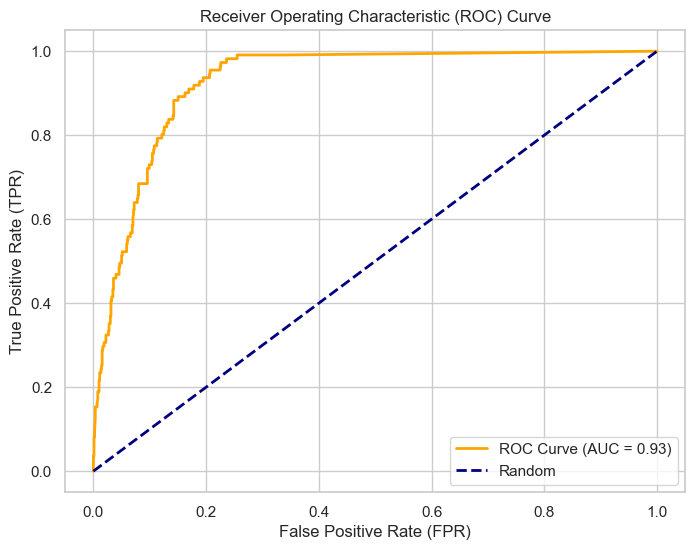

In [90]:
# Get predicted probabilities for class 1
y_pred_prob1 = grid_searches['Random Forest'].predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

# Compute AUC score
auc_score1 = roc_auc_score(y_test, y_pred_prob1)
print("AUC Score:", auc_score1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='orange', lw=2, label='ROC Curve (AUC = {:.2f})'.format(auc_score1))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


The AUC(Area Under the Curve) score is a measure of the model's ability to discriminate between positive and negative examples.
The AUC score of 0.928 suggests that the ROC (Receiver Operating Characteristic) curve for the tuned Random Forest model performs well in distinguishing between positive and negative cases.  In general, an AUC score close to 1.0 indicates a strong classifier.

Precision-Recall Curve

0.5864601847463543


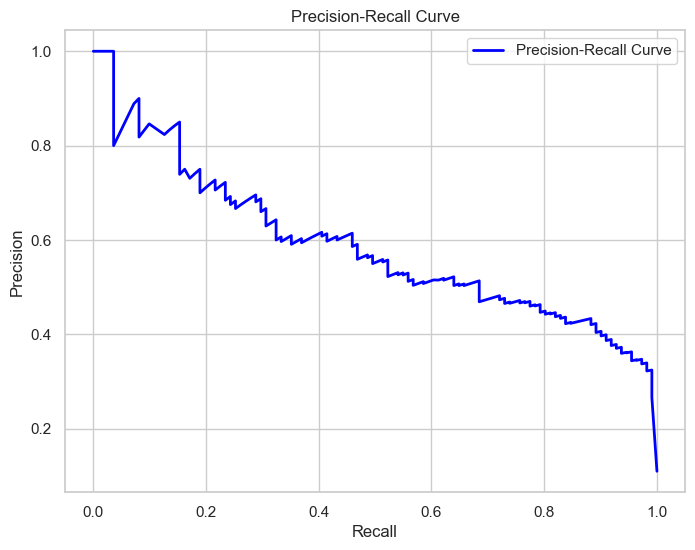

In [93]:
# Get predicted probabilities for positive class
y_probs = grid_searches['Random Forest'].predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Calculate AUC-PR
auc_pr = auc(recall, precision)
print(auc_pr)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


AUC-PR values range from 0 to 1. A higher AUC-PR suggests better performance, with 1 being the ideal value. The model's AUC-PR of 0.60 is decent, indicating reasonable precision and recall trade-offs.

#### Model Persistence

In [92]:
# Save the trained model to a file
model_filename = 'RF_churn_prediction_model.joblib'
joblib.dump(grid_searches['Random Forest'], model_filename)

# Save the encoder
joblib.dump(label_encoder, 'categorical_encoder.joblib')


['categorical_encoder.joblib']

#### ****Business Impact Assessment****

 ***Key Business Metrics***
1. *Customer Retention Rate (CRR):*
   - *Definition:* The percentage of customers retained over a specific period.
2. *Churn Rate:*
   - *Definition:* The percentage of customers who stopped using the product or service during a given time period.
3. *Customer Lifetime Value (CLV):*
   - *Definition:* The predicted net profit attributed to the entire future relationship with a customer.

 ***Key Model Metrics:***
1. *Accuracy:*
   - Overall, how often is the model correct?
2. *Precision:*
   - Out of the predicted churn cases, how many are actually churned? (Minimizing false positives)
3. *Recall (Sensitivity):*
   - Out of the actual churn cases, how many were correctly predicted by the model? (Minimizing false negatives)
4. *F1 Score:*
   - The harmonic mean of precision and recall. Useful when there is an uneven class distribution.
5. *Area Under the ROC Curve (AUC-ROC):*
   - Measures the ability of the model to distinguish between churn and non-churn customers.


 ***Quality Impact Analysis:***
  Data Quality:

- *Completeness:*
  - A few missing values were present for the training dataset wich made the data incomplete
  - These missing values where imputed using the SimpleImputer method. Numerical columns were filled wth the median and categorical ones filled with the mode

- *Accuracy:*
  - Data entries were mostly accurate with just a few being inaccurate 
  - These few inaccuracies were converted to NaN datatypes and treated as null values 

- *Consistency:*
  - the dataset was consistently recorded 

 ***Feature Importance:***

Identify key features:
  - Only features that contributed the most to the model training were prioritized to prevent model complexity and overfitting
  - This was done using the Select Kbest method
Feature Engineering:
  - Consider creating new features or transforming existing ones to enhance model performance.

 ***Model Evaluation:***
Presentation of Evaluation Results:

For the best-performing model, Random Forest, the following evaluation metrics were obtained: 

 Classification Report for Random Forest:

          precision    recall  f1-score   support

       0       0.95      0.94      0.95       898
       1       0.58      0.64      0.61       111

accuracy                           0.91      1009
macro avg      0.77      0.79      0.78      1009
weighted avg   0.91      0.91      0.91      1009


Confusion Matrix for Random Forest:
[[846 52]
[ 40 71]]

***Model Performance Summary:***

The Random Forest model demonstrates high accuracy (91%) and precision (0.95) for non-churned customers (Class 0). However, it exhibits weaknesses, including relatively low precision (0.58) for churned customers (Class 1), moderate recall (0.64) for churned cases, potential impact from imbalanced classes, and an imbalance in F1-scores between the two classes (0.95 for Class 0 and 0.61 for Class 1). Improvements are needed to enhance the model's ability to correctly identify and capture instances of churn.

***Discussion of Implications:***
While the model provides valuable insights, continuous monitoring, fine-tuning, and potential incorporation of additional features are recommended to enhance its effectiveness in supporting proactive measures aimed at customer retention. Proactive measures derived from the model should be tailored to address the specific characteristics of customers at risk of churning.


 ***Other Impact Analysis Considerations:***
1. *Operational Impact:*
   - How will the model's predictions be used in day-to-day operations?
   - What actions will be taken based on the model's output, and how will it affect operational workflows?
2. *Resource Allocation:*
   - Consider the allocation of resources for implementing preventive measures.
   - How much budget, manpower, and technology resources will be required to act on the model's predictions?
3. *Customer Experience:*
   - Assess the impact on customer experience. Will the model's predictions enhance or disrupt the customer journey?
   - How can the model be leveraged to improve customer satisfaction?
4. *Proactive Measures:*
   - Evaluate the effectiveness of proactive measures based on the model's predictions.
   - Are the preventive strategies aligned with customer needs and expectations?
5. *Monitoring and Adaptation:*
   - Establish a plan for monitoring the model's performance over time.
   - How will the model be adapted or updated based on changing customer behaviors and business dynamics?
6. *Business Goals Alignment:*
   - Ensure that the model's predictions align with broader business goals and objectives.
   - How does the model contribute to reducing customer churn and increasing customer retention?
7. *Risk Mitigation:*
   - Identify potential risks associated with model predictions and establish mitigation strategies.
   - What safeguards are in place to minimize the impact of false predictions or model errors?


#### ***Documentation***

**Objective and Problem Definition:**

The primary objective of this machine learning project is to predict customer churn in a telecommunications company. Customer churn, or the loss of customers, poses a significant challenge for businesses. The goal is to leverage machine learning techniques to accurately identify customers who are likely to churn. By doing so, the company can implement proactive measures to retain customers and enhance overall customer satisfaction.

*Key Points:*
- Predict customer churn in the telecommunications company.
- Implement proactive measures to reduce churn and improve customer retention.
- Address the business challenge of customer loss through predictive modeling.

This problem is of strategic importance to the business, as it aligns with the broader goal of enhancing customer loyalty and maximizing the company's long-term profitability.


**Data Exploration and Preprocessing:**

In this phase, a thorough exploration and preprocessing of the dataset were conducted to ensure its suitability for building a predictive model. The following key steps were undertaken:

1. *Exploratory Data Analysis (EDA):*
   - Analyzed the dataset to understand its structure, features, and distribution.
   - Checked for potential patterns, trends, and outliers that could impact model performance.
   - Visualized relevant statistics using descriptive statistics, histograms, and correlation matrices.

2. *Handling Missing Values:*
   - Investigated and addressed missing values in the dataset.
   - Employed appropriate strategies such as imputation based on the nature and impact of missing data.

3. *Feature Engineering:*
   - Transformed some existing Features to enhance the model's predictive power.
   - Considered log transformations, scaling, and one-hot encoding for categorical variables.

4. *Data Splitting:*
   - Segmented the dataset into training and testing sets to facilitate model training and evaluation.

These steps collectively contributed to the creation of a clean, representative, and well-prepared dataset for subsequent model development.


**Model Selection and Tuning:**

The process of selecting and tuning the machine learning model involved several crucial steps to ensure optimal predictive performance. Here's an overview:

1. *Model Selection:*
   - Explored various machine learning algorithms suitable for the customer churn prediction task.
   - Considered models like Decision Trees, Random Forest,Logistic Regression, Stochastic Gradient Descent, K-Nearest Neighbours and Support Vector Machines (SVM) due to their relevance in classification problems.

2. *Hyperparameter Tuning:*
   - Utilized grid search along with cross-validation to identify optimal hyperparameters for each candidate model.
   - Tuned hyperparameters to enhance the model's ability to generalize well to unseen data.

3. *Handling Imbalanced Classes:*
   - Acknowledged the class imbalance issue, particularly in the context of predicting customer churn.
   - Employed the Synthetic Minority Over-sampling Technique (SMOTE) technique during model training to address class imbalance.

4. *Performance Evaluation:*
   - Evaluated model performance using metrics such as accuracy, precision, recall, and F1-score.
   - Leveraged the grid search results to identify the best-performing model based on the chosen evaluation metric.

The chosen Random Forest model demonstrated superior performance in predicting customer churn, achieving an accuracy of 91% on the test set. Further details on its metrics and implications are provided


**Discussion of Implications on Business Objectives:**

The performance of the machine learning model in predicting customer churn has significant implications for business objectives. 

1. *Proactive Measures:*
   - The accurate prediction of customer churn allows the implementation of proactive measures to retain customers.
   - By identifying potential churners early, the business can take targeted actions to address customer concerns, offer incentives, or introduce loyalty programs.

2. *Resource Allocation:*
   - The model's precision and recall metrics influence resource allocation for retention strategies.
   - High precision for non-churned customers ensures that resources are not unnecessarily allocated to customers who are unlikely to churn.
   - Improving precision for churned customers can optimize resource allocation for retention efforts.

3. *Impact on Revenue:*
   - Retaining customers directly impacts the company's revenue by reducing customer churn.
   - The model's ability to accurately predict churn contributes to maintaining a stable customer base and, consequently, revenue generation.

4. *Customer Satisfaction:*
   - Implementing proactive measures based on model predictions positively influences customer satisfaction.
   - Addressing potential issues before customers churn enhances overall satisfaction and loyalty.

5. *Continuous Improvement:*
   - Regularly assessing and updating the model based on new data ensures continuous improvement.
   - Monitoring the model's performance allows for timely adjustments and enhancements, aligning with the dynamic nature of customer behavior.

By aligning the model's predictions with these business objectives, the company can make informed decisions to enhance customer retention and overall business performance.


**Recommendations for Future Work:**

1. *Feature Engineering:*
   - Explore additional features or transformations that could enhance the model's predictive power.
   - Consider domain-specific features or external data sources that might provide valuable insights into customer behavior.

2. *Model Ensemble:*
   - Experiment with ensemble methods that combine predictions from multiple models.
   - Ensemble methods, such as stacking or bagging, might further improve the model's robustness and generalization.

3. *Customer Segmentation:*
   - Explore customer segmentation to tailor retention strategies based on different customer profiles.
   - Clustering techniques can help identify distinct customer segments with varying churn probabilities.

4. *Continuous Monitoring:*
   - Implement a system for continuous monitoring of model performance in a production environment.
   - Set up alerts for significant deviations in performance metrics, prompting timely intervention and model updates.

5. *External Factors:*
   - Consider incorporating external factors that might influence customer churn, such as economic conditions, industry trends, or competitive factors.
   - Analyze the impact of these external factors on the model's predictions and adapt accordingly.

6. *Feedback Loop:*
   - Establish a feedback loop involving relevant stakeholders, including customer support and marketing teams.
   - Gather feedback on the model's predictions from frontline teams to improve its alignment with real-world scenarios.

By addressing these recommendations, the model's effectiveness in predicting customer churn can be further enhanced, contributing to more informed business decisions and proactive customer retention strategies.


**Conclusion:**

In conclusion, the creation of an effective customer churn prediction model is pivotal for the telecommunications industry to proactively retain customers. Our journey started with a thorough data exploration and preprocessing phase, where we not only uncovered insights but also addressed critical issues like missing values and ensured data accuracy.

Through a meticulous model selection and tuning process, the Random Forest algorithm emerged as the top-performing model. While showcasing impressive accuracy and balanced recall, there are identified areas for refinement, particularly in precision for predicting churned customers.

The quality impact analysis underscored the significance of data completeness, accuracy, and consistency, emphasizing our commitment to maintaining the highest standards for data quality—a cornerstone for reliable predictions.

Documentation is more than a formality; it's a strategic asset. By documenting our process, decisions, and results, we create a comprehensive resource for future collaborations and ensure transparency in our model development journey.

Considering the implications on business objectives, we recognize the model's strengths and acknowledge areas for improvement. Our recommendations for future work outline a roadmap for continuous enhancement, encompassing feature engineering, ongoing monitoring, and the incorporation of external factors.

This is not the end; it's the beginning of an iterative process aimed at refining our model and staying ahead in the dynamic landscape of customer retention. Through strategic adaptations and a commitment to excellence, we pave the way for a robust and adaptive customer churn prediction system that aligns seamlessly with our business goals.
